### <font color='green'>1. Description<font>

Click though rate prediction using logistic regression. Please download the data from https://www.kaggle.com/c/avazu-ctr-prediction/ manually (registration required) and place `CTR_train` file in `datasets` directory. Only part of the data is used, because it takes too large memory for one VE card.

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding. This data is 11 days worth of Avazu data to build and test prediction models.

### <font color='green'>2. Data Preprocessing<font>

For CTR classification we will perform some data preparation and data cleaning steps. We will generate feature vectors using sklearn TF-IDF for review text.

In [1]:
import os
import time
import pandas as pd
from collections import OrderedDict
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
def preprocess_data(fname):
    '''
    For CTR classification we will perform some data preparation and data cleaning steps.
    '''
    #Sample size of 1 million has been taken for execution from CTR dataset
    n_rows =  800000
    df = pd.read_csv(fname, nrows=n_rows)
    class_names = {0:'Not click', 1:'Click'}
    print(df.click.value_counts().rename(index = class_names))
    # We dropped 'click', 'id', 'hour', 'device_id', 'device_ip' from the dataset,
    # which does not contribute the prediction.
    x = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
    y = df['click'].values
    n_rows = df.shape[0]
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.05)
    # Other features are one-hot encoded; so the feature matrix becomes sparse matrix
    enc = OneHotEncoder(handle_unknown='ignore')
    x_train_enc = enc.fit_transform(x_train)
    x_test_enc = enc.transform(x_test)
    return x_train_enc, x_test_enc, y_train, y_test

In [3]:
#---- Data Preparation ----

DATA_FILE = "datasets/ctr_train.csv"
x_train, x_test, y_train, y_test = preprocess_data(DATA_FILE)
print("shape of train data: {}".format(x_train.shape))
print("shape of test data: {}".format(x_test.shape))

Not click    669744
Click        130256
Name: click, dtype: int64
shape of train data: (760000, 11452)
shape of test data: (40000, 11452)


<AxesSubplot:ylabel='count'>

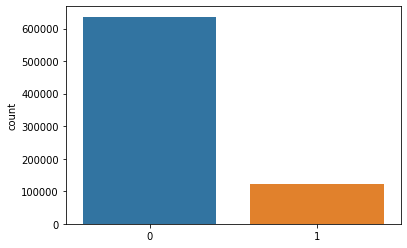

In [4]:
sns.countplot(y_train)

### <font color='green'>3. Algorithm Evaluation<font>

In [5]:
train_time = []
test_time = []
accuracy = []
precision = []
recall = []
f1 = []
estimator_name = []

In [6]:
def evaluate(estimator, estimator_nm, 
             x_train, y_train,
             x_test, y_test):
    '''
    To generate performance report for both frovedis and sklearn estimators
    '''
    estimator_name.append(estimator_nm)
    start_time = time.time()
    estimator.fit(x_train, y_train)
    train_time.append(round(time.time() - start_time, 4))

    start_time = time.time()
    pred_y = estimator.predict(x_test)
    test_time.append(round(time.time() - start_time, 4))
    accuracy.append(metrics.accuracy_score(y_test, pred_y))
    precision.append(metrics.precision_score(y_test, pred_y))
    recall.append(metrics.recall_score(y_test, pred_y))
    f1.append(metrics.f1_score(y_test, pred_y))
    return metrics.classification_report(y_test, pred_y)

#### 3.1 Binary LogisticRegression with sag solver

In [7]:
#Demo: Binary Logistic Regression with sag solver

import frovedis
TARGET = "binary_logistic_regression_sag"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.linear_model import LogisticRegression as frovLogisticRegression
f_est = frovLogisticRegression(penalty='l2', solver='sag')
E_NM = TARGET + "_frovedis_" + frovedis.__version__
f_report = evaluate(f_est, E_NM, \
                    x_train, y_train, x_test, y_test)
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.linear_model import LogisticRegression as skLogisticRegression
s_est = skLogisticRegression(penalty='l2', solver='sag')
E_NM = TARGET + "_sklearn_" + sklearn.__version__
s_report = evaluate(s_est, E_NM, \
                    x_train, y_train, x_test, y_test)

print("Frovedis LogisticRegression matrices: ")
print(f_report)
print("Sklearn LogisticRegression matrices: ")
print(s_report)

Frovedis LogisticRegression matrices: 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     33473
           1       0.52      0.16      0.25      6527

    accuracy                           0.84     40000
   macro avg       0.69      0.57      0.58     40000
weighted avg       0.80      0.84      0.80     40000

Sklearn LogisticRegression matrices: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     33473
           1       0.52      0.11      0.18      6527

    accuracy                           0.84     40000
   macro avg       0.69      0.55      0.55     40000
weighted avg       0.80      0.84      0.79     40000



#### 3.2 Linear SVC

In [8]:
# Demo: Linear SVC

import frovedis
TARGET = "Linear_SVC"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.svm import LinearSVC as frovSVC

f_est = frovSVC(loss='hinge', max_iter=10000)
E_NM = TARGET + "_frovedis_" + frovedis.__version__
f_report = evaluate(f_est, E_NM, \
                    x_train, y_train, x_test, y_test)
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.svm import LinearSVC as skSVC
s_est = skSVC(loss='hinge', max_iter=10000)
E_NM = TARGET + "_sklearn_" + sklearn.__version__
s_report = evaluate(s_est, E_NM, \
                    x_train, y_train, x_test, y_test)

# SVC: Precision, Recall and F1 score for each class
print("Frovedis Linear SVC metrices: ")
print(f_report)
print("Sklearn Linear SVC metrices: ")
print(s_report)

Frovedis Linear SVC metrices: 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     33473
           1       0.57      0.04      0.08      6527

    accuracy                           0.84     40000
   macro avg       0.70      0.52      0.50     40000
weighted avg       0.80      0.84      0.78     40000

Sklearn Linear SVC metrices: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     33473
           1       0.53      0.12      0.19      6527

    accuracy                           0.84     40000
   macro avg       0.69      0.55      0.55     40000
weighted avg       0.80      0.84      0.79     40000



/home/adityaw/virt1/lib64/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### 4. Performance summary

In [9]:
# ---- evaluation summary ----
summary = pd.DataFrame(OrderedDict({ "estimator": estimator_name,
                                     "train time": train_time,
                                     "test time": test_time,
                                     "accuracy": accuracy,
                                     "precision": precision,
                                     "recall": recall,
                                     "f1-score": f1
                                  }))
summary

,estimator,train time,test time,accuracy,precision,recall,f1-score
0,binary_logistic_regression_sag_frovedis_0.9.10,1.7105,0.0586,0.838925,0.520388,0.164241,0.249680
1,binary_logistic_regression_sag_sklearn_0.24.1,18.8960,0.0287,0.838425,0.523358,0.109851,0.181588
2,Linear_SVC_frovedis_0.9.10,13.6409,0.0616,0.838475,0.566000,0.043358,0.080546
3,Linear_SVC_sklearn_0.24.1,1941.1949,0.0287,0.838850,0.527759,0.117972,0.192837
